# Melanoma starter pipeline by [@shonenkov](https://www.kaggle.com/shonenkov)

# Main ideas


- Using External Data
- StratifyGroupKFold
- Focal Loss / Label Smoothing
- BalanceClassSampler
- SimpleAugs
- 512x512 image size
- EfficientNet

# Dependencies

In [1]:
!pip install -q efficientnet_pytorch > /dev/null

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
from glob import glob
import pandas as pd
from sklearn.model_selection import GroupKFold
import cv2
from skimage import io
import albumentations as A
import torch
import os
from datetime import datetime
import time
import random
import cv2
import pandas as pd
import numpy as np
import albumentations as A
import matplotlib.pyplot as plt
from albumentations.pytorch.transforms import ToTensorV2
from sklearn.model_selection import StratifiedKFold
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler
from torch.nn import functional as F
from glob import glob
import sklearn
from torch import nn
import warnings

warnings.filterwarnings("ignore") 
warnings.filterwarnings("ignore", category=DeprecationWarning) 

SEED = 42

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(SEED)

# External data

I have prepared kernel with merging data. Don't forget to read [this kernel](https://www.kaggle.com/shonenkov/merge-external-data) ;)

In [3]:
DATA_PATH = '../input/melanoma-merged-external-data-512x512-jpeg'

# StratifyGroupKFold

I think group by patient_id is very important. Also I think that stratify by sex, target, source, anatom_site_general_challenge also useful.
Code with getting folds you can find [here](https://www.kaggle.com/shonenkov/merge-external-data)

In [4]:
df_folds = pd.read_csv(f'{DATA_PATH}/folds.csv', index_col='image_id')

In [5]:
set(df_folds[df_folds['fold'] == 0]['patient_id'].values).intersection(df_folds[df_folds['fold'] == 1]['patient_id'].values)

set()

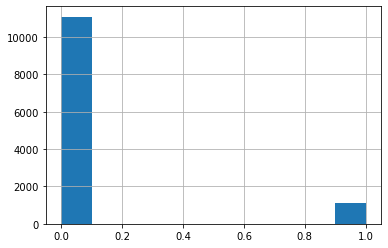

In [6]:
df_folds[df_folds['fold'] == 0]['target'].hist();

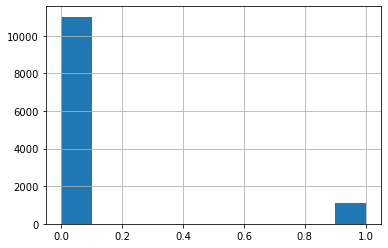

In [7]:
df_folds[df_folds['fold'] == 1]['target'].hist();

# Augmentations

In [8]:
def get_train_transforms():
    return A.Compose([
            A.RandomSizedCrop(min_max_height=(400, 400), height=512, width=512, p=0.5),
            A.RandomRotate90(p=0.5),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.Resize(height=512, width=512, p=1),
            A.Cutout(num_holes=8, max_h_size=64, max_w_size=64, fill_value=0, p=0.5),
            ToTensorV2(p=1.0),                  
        ], p=1.0)

def get_valid_transforms():
    return A.Compose([
            A.Resize(height=512, width=512, p=1.0),
            ToTensorV2(p=1.0),
        ], p=1.0)

# Dataset

In [9]:
TRAIN_ROOT_PATH = f'{DATA_PATH}/512x512-dataset-melanoma/512x512-dataset-melanoma'

def onehot(size, target):
    vec = torch.zeros(size, dtype=torch.float32)
    vec[target] = 1.
    return vec

class DatasetRetriever(Dataset):

    def __init__(self, image_ids, labels, transforms=None):
        super().__init__()
        self.image_ids = image_ids
        self.labels = labels
        self.transforms = transforms

    def __getitem__(self, idx: int):
        image_id = self.image_ids[idx]
        image = cv2.imread(f'{TRAIN_ROOT_PATH}/{image_id}.jpg', cv2.IMREAD_COLOR)
        image = image.astype(np.float32) / 255.0

        label = self.labels[idx]

        if self.transforms:
            sample = {'image': image}
            sample = self.transforms(**sample)
            image = sample['image']

        target = onehot(2, label)
        return image, target

    def __len__(self) -> int:
        return self.image_ids.shape[0]

    def get_labels(self):
        return list(self.labels)

# Metrics

In [10]:
from sklearn import metrics

class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


class RocAucMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.y_true = np.array([0,1])
        self.y_pred = np.array([0.5,0.5])
        self.score = 0

    def update(self, y_true, y_pred):
        y_true = y_true.cpu().numpy().argmax(axis=1).clip(min=0, max=1).astype(int)
        # y_pred = 1 - nn.functional.softmax(y_pred, dim=1).data.cpu().numpy()[:,0]
        y_pred = nn.functional.softmax(y_pred, dim=1).data.cpu().numpy()[:,1]
        self.y_true = np.hstack((self.y_true, y_true))
        self.y_pred = np.hstack((self.y_pred, y_pred))
        self.score = sklearn.metrics.roc_auc_score(self.y_true, self.y_pred)

    @property
    def avg(self):
        return self.score

    
class APScoreMeter(RocAucMeter):
    def __init__(self):
        super(APScoreMeter, self).__init__()

    def update(self, y_true, y_pred):
        y_true = y_true.cpu().numpy().argmax(axis=1).clip(min=0, max=1).astype(int)
        y_pred = nn.functional.softmax(y_pred, dim=1).data.cpu().numpy()[:,1]
        self.y_true = np.hstack((self.y_true, y_true))
        self.y_pred = np.hstack((self.y_pred, y_pred))
        self.score = sklearn.metrics.average_precision_score(self.y_true, self.y_pred)

# Loss

In [11]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, logits=False, reduce=True):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.logits = logits
        self.reduce = reduce

    def forward(self, inputs, targets):
        if self.logits:
            BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets)
        else:
            BCE_loss = F.binary_cross_entropy(inputs, targets)

        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss

        if self.reduce:
            return torch.mean(F_loss)
        else:
            return F_loss
        
class LabelSmoothing(nn.Module):
    def __init__(self, smoothing = 0.1):
        super(LabelSmoothing, self).__init__()
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing

    def forward(self, x, target):
        if self.training:
            x = x.float()
            target = target.float()
            logprobs = torch.nn.functional.log_softmax(x, dim = -1)

            nll_loss = -logprobs * target
            nll_loss = nll_loss.sum(-1)
    
            smooth_loss = -logprobs.mean(dim=-1)

            loss = self.confidence * nll_loss + self.smoothing * smooth_loss

            return loss.mean()
        else:
            return torch.nn.functional.cross_entropy(x, target)

# Net

In [12]:
from efficientnet_pytorch import EfficientNet

def get_net():
    net = EfficientNet.from_pretrained('efficientnet-b5')
    net._fc = nn.Linear(in_features=2048, out_features=2, bias=True)
    return net

net = get_net().cuda()

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b5-b6417697.pth" to /root/.cache/torch/checkpoints/efficientnet-b5-b6417697.pth



Loaded pretrained weights for efficientnet-b5


# Fitter

In [13]:
class Fitter:
    
    def __init__(self, model, device, config, folder):
        self.config = config
        self.epoch = 0

        self.base_dir = f'./{folder}'
        if not os.path.exists(self.base_dir):
            os.makedirs(self.base_dir)

        self.log_path = f'{self.base_dir}/log.txt'
        self.best_score = 0
        self.best_loss = 10**5
        self.best_ap = 0
        
        self.model = model
        self.device = device

        param_optimizer = list(self.model.named_parameters())
        no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
        optimizer_grouped_parameters = [
            {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.001},
            {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
        ] 

        self.optimizer = torch.optim.AdamW(self.model.parameters(), lr=config.lr)
        self.scheduler = config.SchedulerClass(self.optimizer, **config.scheduler_params)

#         self.criterion = FocalLoss(logits=True).to(self.device)
        self.criterion = LabelSmoothing().to(self.device)
        self.log(f'Fitter prepared. Device is {self.device}')

    def fit(self, train_loader, validation_loader):
        for e in range(self.config.n_epochs):
            if self.config.verbose:
                lr = self.optimizer.param_groups[0]['lr']
                timestamp = datetime.utcnow().isoformat()
                self.log(f'\n{timestamp}\nLR: {lr}')

            t = time.time()
            summary_loss, roc_auc_scores, ap_scores = self.train_one_epoch(train_loader)
            self.log(f'[RESULT]: Train. Epoch: {self.epoch}, summary_loss: {summary_loss.avg:.5f}, roc_auc: {roc_auc_scores.avg:.5f}, ap: {ap_scores.avg:.5f}, time: {(time.time() - t):.5f}')

            t = time.time()
            summary_loss, roc_auc_scores, ap_scores = self.validation(validation_loader)

            self.log(f'[RESULT]: Val. Epoch: {self.epoch}, summary_loss: {summary_loss.avg:.5f}, roc_auc: {roc_auc_scores.avg:.5f}, ap: {ap_scores.avg:.5f}, time: {(time.time() - t):.5f}')
            if summary_loss.avg < self.best_loss:
                self.best_loss = summary_loss.avg
                self.save_model(f'{self.base_dir}/best-loss-checkpoint-{str(self.epoch).zfill(3)}epoch.bin')
                for path in sorted(glob(f'{self.base_dir}/best-loss-checkpoint-*epoch.bin'))[:-2]:
                    os.remove(path)
                    
            if roc_auc_scores.avg > self.best_score:
                self.best_score = roc_auc_scores.avg
                self.save_model(f'{self.base_dir}/best-score-checkpoint-{str(self.epoch).zfill(3)}epoch.bin')
                for path in sorted(glob(f'{self.base_dir}/best-score-checkpoint-*epoch.bin'))[:-2]:
                    os.remove(path)
                    
            if ap_scores.avg > self.best_ap:
                self.best_ap = ap_scores.avg
                self.save_model(f'{self.base_dir}/best-ap-checkpoint-{str(self.epoch).zfill(3)}epoch.bin')
                for path in sorted(glob(f'{self.base_dir}/best-ap-checkpoint-*epoch.bin'))[:-2]:
                    os.remove(path)

            if self.config.validation_scheduler:
                self.scheduler.step(metrics=summary_loss.avg)

            self.epoch += 1

    def validation(self, val_loader):
        self.model.eval()
        summary_loss = AverageMeter()
        roc_auc_scores = RocAucMeter()
        ap_scores = APScoreMeter()
        t = time.time()
        for step, (images, targets) in enumerate(val_loader):
            if self.config.verbose:
                if step % self.config.verbose_step == 0:
                    print(
                        f'Val Step {step}/{len(val_loader)}, ' + \
                        f'summary_loss: {summary_loss.avg:.5f}, roc_auc: {roc_auc_scores.avg:.5f}, ap: {ap_scores.avg:.5f} ' + \
                        f'time: {(time.time() - t):.5f}', end='\r'
                    )
            with torch.no_grad():
                targets = targets.to(self.device).float()
                batch_size = images.shape[0]
                images = images.to(self.device).float()
                outputs = self.model(images)
                loss = self.criterion(outputs, targets)
                roc_auc_scores.update(targets, outputs)
                ap_scores.update(targets, outputs)
                summary_loss.update(loss.detach().item(), batch_size)

        return summary_loss, roc_auc_scores, ap_scores

    def train_one_epoch(self, train_loader):
        self.model.train()
        summary_loss = AverageMeter()
        roc_auc_scores = RocAucMeter()
        ap_scores = APScoreMeter()
        t = time.time()
        for step, (images, targets) in enumerate(train_loader):
            if self.config.verbose:
                if step % self.config.verbose_step == 0:
                    print(
                        f'Train Step {step}/{len(train_loader)}, ' + \
                        f'summary_loss: {summary_loss.avg:.5f}, roc_auc: {roc_auc_scores.avg:.5f}, ap: {ap_scores.avg:.5f} ' + \
                        f'time: {(time.time() - t):.5f}', end='\r'
                    )
            
            targets = targets.to(self.device).float()
            images = images.to(self.device).float()
            batch_size = images.shape[0]

            self.optimizer.zero_grad()
            outputs = self.model(images)
            loss = self.criterion(outputs, targets)
            loss.backward()
            
            roc_auc_scores.update(targets, outputs)
            ap_scores.update(targets, outputs)
            summary_loss.update(loss.detach().item(), batch_size)

            self.optimizer.step()

            if self.config.step_scheduler:
                self.scheduler.step()

        return summary_loss, roc_auc_scores, ap_scores
    
    def save_model(self, path):
        self.model.eval()
        torch.save(self.model.state_dict(),path)

    def save(self, path):
        self.model.eval()
        torch.save({
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'scheduler_state_dict': self.scheduler.state_dict(),
            'best_score': self.best_score,
            'best_ap': self.best_ap,
            'best_loss': self.best_loss,
            'epoch': self.epoch,
        }, path)

    def load(self, path):
        checkpoint = torch.load(path)
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        self.best_score = checkpoint['best_score']
        self.best_ap = checkpoint['best_ap']
        self.best_loss = checkpoint['best_loss']
        self.epoch = checkpoint['epoch']
        
    def log(self, message):
        if self.config.verbose:
            print(message)
        with open(self.log_path, 'a+') as logger:
            logger.write(f'{message}\n')

In [14]:
class TrainGlobalConfig:
    num_workers = 2
    batch_size = 8 
    n_epochs = 20
    lr = 0.00003

    # -------------------
    verbose = True
    verbose_step = 1
    # -------------------

    # --------------------
    step_scheduler = False  # do scheduler.step after optimizer.step
    validation_scheduler = True  # do scheduler.step after validation stage loss

#     SchedulerClass = torch.optim.lr_scheduler.OneCycleLR
#     scheduler_params = dict(
#         max_lr=0.001,
#         epochs=n_epochs,
#         steps_per_epoch=int(len(train_dataset) / batch_size),
#         pct_start=0.1,
#         anneal_strategy='cos', 
#         final_div_factor=10**5
#     )
    
    SchedulerClass = torch.optim.lr_scheduler.ReduceLROnPlateau
    scheduler_params = dict(
        mode='min',
        factor=0.8,
        patience=1,
        verbose=False, 
        threshold=0.0001,
        threshold_mode='abs',
        cooldown=0, 
        min_lr=1e-8,
        eps=1e-08
    )
    # --------------------

# Save all states for "honest" training of folds

In [15]:
fitter = Fitter(model=net, device=torch.device('cuda:0'), config=TrainGlobalConfig, folder='base_state')
BASE_STATE_PATH = f'{fitter.base_dir}/base_state.bin'
fitter.save(BASE_STATE_PATH)

Fitter prepared. Device is cuda:0


In [16]:
from catalyst.data.sampler import BalanceClassSampler

def train_fold(fold_number):

    train_dataset = DatasetRetriever(
        image_ids=df_folds[df_folds['fold'] != fold_number].index.values,
        labels=df_folds[df_folds['fold'] != fold_number].target.values,
        transforms=get_train_transforms(),
    )

    df_val = df_folds[(df_folds['fold'] == fold_number) & (df_folds['source'] == 'ISIC20')]

    validation_dataset = DatasetRetriever(
        image_ids=df_val.index.values,
        labels=df_val.target.values,
        transforms=get_valid_transforms(),
    )

    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        sampler=BalanceClassSampler(labels=train_dataset.get_labels(), mode="downsampling"),
        batch_size=TrainGlobalConfig.batch_size,
        pin_memory=False,
        drop_last=True,
        num_workers=TrainGlobalConfig.num_workers,
    )
    val_loader = torch.utils.data.DataLoader(
        validation_dataset, 
        batch_size=TrainGlobalConfig.batch_size,
        num_workers=TrainGlobalConfig.num_workers,
        shuffle=False,
        sampler=SequentialSampler(validation_dataset),
        pin_memory=False,
    )

    fitter = Fitter(model=net, device=torch.device('cuda:0'), config=TrainGlobalConfig, folder=f'fold{fold_number}')
    fitter.load(BASE_STATE_PATH)
    fitter.fit(train_loader, val_loader)

In [17]:
import warnings

warnings.filterwarnings("ignore", category=DeprecationWarning) 

for fold_number in range(1): # range(5)
    train_fold(fold_number=fold_number)

Fitter prepared. Device is cuda:0

2020-06-05T05:06:54.833729
LR: 3e-05
[RESULT]: Train. Epoch: 0, summary_loss: 0.52805, roc_auc: 0.85103, ap: 0.84112, time: 797.09923
[RESULT]: Val. Epoch: 0, summary_loss: 0.31345, roc_auc: 0.89614, ap: 0.21135, time: 147.94666

2020-06-05T05:22:40.383111
LR: 3e-05
[RESULT]: Train. Epoch: 1, summary_loss: 0.48091, roc_auc: 0.89080, ap: 0.88059, time: 794.29858
[RESULT]: Val. Epoch: 1, summary_loss: 0.29728, roc_auc: 0.92565, ap: 0.27764, time: 147.87266

2020-06-05T05:38:23.143641
LR: 3e-05
[RESULT]: Train. Epoch: 2, summary_loss: 0.46159, roc_auc: 0.90506, ap: 0.89870, time: 795.10489
[RESULT]: Val. Epoch: 2, summary_loss: 0.26277, roc_auc: 0.92242, ap: 0.29737, time: 147.70316

2020-06-05T05:54:06.319534
LR: 3e-05
[RESULT]: Train. Epoch: 3, summary_loss: 0.45305, roc_auc: 0.91111, ap: 0.90125, time: 792.95324
[RESULT]: Val. Epoch: 3, summary_loss: 0.26828, roc_auc: 0.93312, ap: 0.31940, time: 147.96768

2020-06-05T06:09:47.596597
LR: 3e-05
[RESULT]

# Thank you for reading my kernel!